In [1]:
from pyspark.sql import SparkSession

# spark instance를 생성
spark = SparkSession.builder.appName("taxi-analysis").getOrCreate()

22/01/04 23:22:38 WARN Utils: Your hostname, iyejun-ui-MacBookAir.local resolves to a loopback address: 127.0.0.1; using 192.168.35.206 instead (on interface en0)
22/01/04 23:22:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/04 23:22:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/01/04 23:22:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/01/04 23:22:40 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [23]:
trip_files = "/Users/yeznable/Documents/GitHub/Data_Processing/Spark/data/trips/*"
zone_file = "/Users/yeznable/Documents/GitHub/Data_Processing/Spark/data/taxi+_zone_lookup.csv"

In [24]:
# 파일을 여러개 불러와 read, 스키마를 함께 읽음
trips_df = spark.read.csv(f"file:///{trip_files}", inferSchema=True, header=True)
zone_df = spark.read.csv(f"file:///{zone_file}", inferSchema=True, header=True)

In [25]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [26]:
# spark dataframe을 생성
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [27]:
# spark sql을 통해 자유롭게 데이터를 다룸
query = """
SELECT 
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
FROM 
    trips t
    LEFT JOIN 
        zone pz
    ON
        t.PULocationID = pz.LocationID
    LEFT JOIN
        zone dz
    ON 
        t.DOLocationID = dz.LocationID
"""
comb_df = spark.sql(query)
comb_df.createOrReplaceTempView("comb")
comb_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [28]:
spark.sql("SELECT pickup_date, pickup_time from comb WHERE pickup_time > 0").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-03-01|         22|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
+-----------+-----------+
only showing top 20 rows



In [29]:
spark.sql("SELECT pickup_date, pickup_time from comb WHERE pickup_date < '2020-12-31'").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|         16|
| 2009-01-01|         16|
| 2009-01-01|          0|
| 2009-01-01|          0|
+-----------+-----------+
only showing top 20 rows



In [30]:
comb_df.select("total_amount").describe().show()
comb_df.select("trip_distance").describe().show()
comb_df.select("passenger_count").describe().show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|         15000700|
|   mean|18.75545205708744|
| stddev|145.7442452805979|
|    min|           -647.8|
|    max|         398469.2|
+-------+-----------------+



+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000700|
|   mean|6.628629402627818|
| stddev|671.7293482115828|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166672|
|   mean|1.4253783104458126|
| stddev|  1.04432704905968|
|    min|                 0|
|    max|                 9|
+-------+------------------+



In [31]:
query = """
SELECT
     DATE_TRUNC('MM', c.pickup_date) AS month,
     COUNT(*) AS trips
FROM
    comb c
GROUP BY
    month
ORDER BY
    month desc
"""
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821430|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371688|
|2021-01-01 00:00:00|1369749|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



In [32]:
# Data Clearning
query = """
SELECT
    *
FROM 
    comb c
WHERE
    c.total_amount < 5000
    AND c.total_amount > 0
    AND c.trip_distance < 100
    AND c.passenger_count < 4
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2021-08-01'
"""
cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [34]:
query = """
SELECT 
    c.pickup_date,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date
"""
pd_df = spark.sql(query).toPandas()

<AxesSubplot:xlabel='pickup_date', ylabel='trips'>

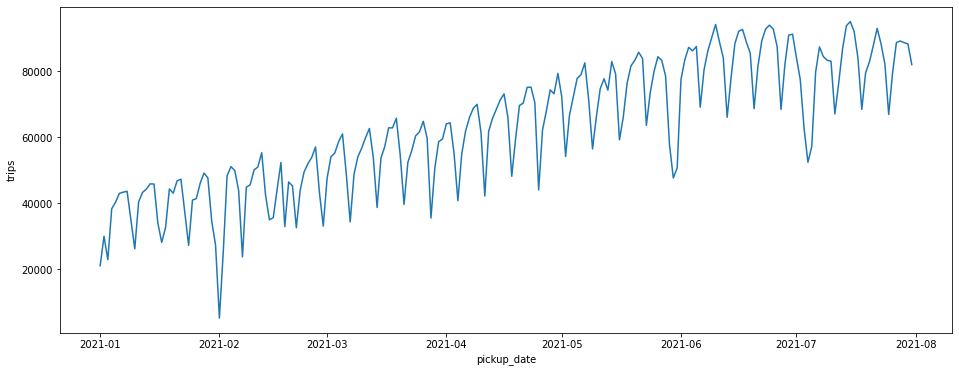

In [35]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x="pickup_date", y="trips", data=pd_df)

In [36]:
query = """
SELECT 
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""
pd_df2 = spark.sql(query).toPandas()

In [37]:
data = pd_df2.groupby("day_of_week").trips.median().to_frame().reset_index()
data["sort_dow"] = data["day_of_week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})

In [38]:
data.sort_values(by="sort_dow", inplace=True)

<AxesSubplot:xlabel='day_of_week', ylabel='trips'>

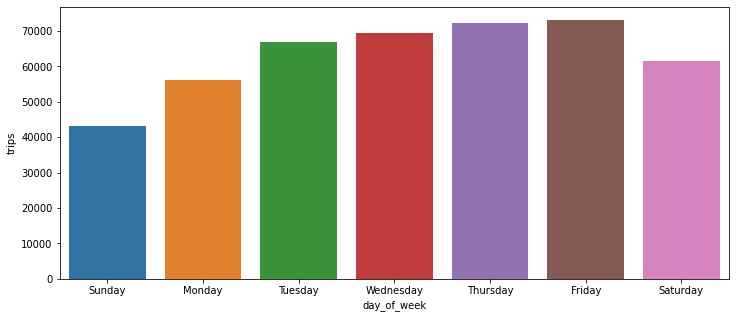

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    x="day_of_week",
    y="trips",
    data=data
)

In [40]:
def get_weekday(data):
    import calendar
    return calendar.day_name[date.weekday()]

spark.udf.register("get_weekday", get_weekday)

22/01/04 23:50:11 WARN SimpleFunctionRegistry: The function get_weekday replaced a previously registered function.


<function __main__.get_weekday(data)>

In [42]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}
def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

spark.udf.register("parse_payment_type", parse_payment_type)

query = """
SELECT 
    parse_payment_type(payment_type),
    count(*) AS trips,
    MEAN(fare_amount) AS mean_fare_amount,
    STD(fare_amount) AS stdev_fare_amount
FROM
    cleaned
GROUP BY
    payment_type
"""

spark.sql(query).show()

22/01/04 23:50:35 WARN SimpleFunctionRegistry: The function parse_payment_type replaced a previously registered function.


+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount| stdev_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10117869|12.216744280835849|10.795080136078592|
|                       No Charge|   58552|11.931005601858176| 15.03784908925372|
|                         Dispute|   23536|12.653402447314749|14.163477726534882|
|                            Cash| 3097149| 11.98103176179123|11.474101590229465|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+

